<a href="https://colab.research.google.com/github/Launcha10/sports_entertaiment_topic_analysis/blob/hayashi-test/travel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!apt install aptitude

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-l

In [3]:
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y

git is already installed at the requested version (1:2.17.1-1ubuntu0.5)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.8)
xz-utils is already installed at the requested version (5.2.2-1.3)
git is already installed at the requested version (1:2.17.1-1ubuntu0.5)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.8)
xz-utils is already installed at the requested version (5.2.2-1.3)
The following NEW packages will be installed:
  file libmagic-mgc{a} libmagic1{a} libmecab-dev libmecab2{a} mecab mecab-ipadic{a} mecab-ipadic-utf8 mecab-jumandic{a} mecab-jumandic-utf8{a} mecab-utils{a} 
The following packages will be REMOVED:
  libnvidia-common-430{u} 
0 packages upgraded, 11 newly installed, 1 to remove and 7 not upgraded.
Need to get 29.3 MB of archives. After unpacking 282 MB will be used.
Get: 1 http://archive.ubuntu.

In [4]:
!pip install mecab-python3==0.7

     |████████████████████████████████| 51kB 2.3MB/s 
  Created wheel for mecab-python3: filename=mecab_python3-0.7-cp36-cp36m-linux_x86_64.whl size=155491 sha256=b49911e086f4175aae491a9bef0ade54d4fd7a7c1ac06d903b160a469d7726d3
  Stored in directory: /root/.cache/pip/wheels/4c/07/3a/5f22ccc9f381f3bc01fa023202061cd1e0e9af855292f005dd
Successfully built mecab-python3


In [0]:
import MeCab

In [6]:
tagger = MeCab.Tagger("-Owakati")
sample = "私はご飯を食べました"
print(tagger.parse(sample))

私 は ご飯 を 食べ まし た 



In [7]:
!pip install gensim
!pip install wordcloud 
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 43.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=3757a11ec59399a620287e99e99828d56d45144d1488c9736d134ec6387d225b
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32040 sha256=42009b149402a8725b28055a3114f7d7ec0481dee8dcec5d9f58b0f8ec717ecd
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import glob
# import numpy as np
import random
from tqdm import tqdm
import math
import MeCab
import urllib
import gensim
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud
from PIL import Image
import matplotlib
import matplotlib.pylab as plt

# np.random.seed(0)
random.seed(0)
FONT = "/content/drive/My Drive/ernie/travel_data/font/HuiFont29.ttf"

In [0]:
# paths to textss
text_paths = glob.glob('/content/drive/My Drive/ernie/travel_data/text/**/*.txt')

# define stop words
req = urllib.request.Request('http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt')
with urllib.request.urlopen(req) as res:
    stopwords = res.read().decode('utf-8').split('\r\n')
while '' in stopwords:
    stopwords.remove('')

In [0]:
def analyzer(text, mecab, stopwords=[], target_part_of_speech=['proper_noun', 'noun', 'verb', 'adjective']):

    node = mecab.parseToNode(text)
    words = []

    while node:

        features = node.feature.split(',')
        surface = features[6]

        if (surface == '*') or (len(surface) < 2) or (surface in stopwords):
            node = node.next
            continue

        noun_flag = (features[0] == '名詞')
        proper_noun_flag = (features[0] == '名詞') & (features[1] == '固有名詞')
        verb_flag = (features[0] == '動詞') & (features[1] == '自立')
        adjective_flag = (features[0] == '形容詞') & (features[1] == '自立')


        if ('proper_noun' in target_part_of_speech) & proper_noun_flag:
            words.append(surface)
        elif ('noun' in target_part_of_speech) & noun_flag:
            words.append(surface)
        elif ('verb' in target_part_of_speech) & verb_flag:
            words.append(surface)
        elif ('adjective' in target_part_of_speech) & adjective_flag:
            words.append(surface)

        node = node.next

    return words



In [0]:
# make dictionary and corpus
mecab = MeCab.Tagger('-Owakati')
titles = []
texts = []
for text_path in text_paths:

    text = open(text_path, 'r').read()
    text = text.split('\n')
    title = text[2]
    text = ' '.join(text[3:])
    words = analyzer(text, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])
    texts.append(words)

dictionary = gensim.corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=3, no_above=0.5)
corpus = [dictionary.doc2bow(t) for t in texts]

In [12]:
print(open(text_paths[0], 'r').read())

http://news.livedoor.com/article/detail/5978741/
2011-10-30T10:15:00+0900
【DVDエンター！】誘拐犯に育てられた女が目にした真実は、孤独か幸福か
　2005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初の長編サスペンス『八日目の蝉』。2010年に檀れいと北乃きいの出演によりテレビドラマ化された同作が、2011年4月に永作博美と井上真央の出演によって映画化。そして、劇場公開から半年が過ぎた10月28日、DVD＆ブルーレイとなって発売されました。

八日目の蝉
　妻子ある男と愛し合い、その子を身ごもりながら、あきらめざるをえなかった女。彼女は同時に、男の妻が子供を産んだことを知る。その赤ん坊を見に行った女は、突発的にその子を連れ去り、逃避行を続けた挙句、小豆島に落ち着き、母と娘として暮らしはじめる。


不倫相手の子供を誘拐し、4年間育てた女
　永作博美が演じる野々宮希和子は、不倫相手の子を宿しながらも、彼の「いずれ妻と別れるから、それまで待ってくれ」という常套句を信じて、中絶。後遺症により、二度と子供を産めない身体となってしまいます。その後、不倫相手から彼の妻が出産したことを知らされ、別れを決意。最後に諦めをつけるため、彼らの生後6ヶ月の赤ん坊・恵理菜の顔を見た希和子でしたが、自分に笑顔で向けた恵理菜を見て、思わず誘拐。名前を変えて恵理菜を薫と名付けると、人目を避けて各地を転々とし、二人で幸せな時間を過ごしますが、辿り着いた最後の場所・小豆島で4年の逃避行に終止符を打ちます。


誘拐犯に育てられた女
　4歳になって実の両親と再会を果たした後も、世間から言われの無い中傷を受け、本当の両親との関係を築けないまま、21歳の大学生へと成長した恵理菜。過去と向き合うことを避けてきた恵理菜でしたが、劇団ひとりが演じる不倫相手・岸田孝史の子を宿し、ずっと憎み続けてきた希和子と同じ道を歩んでいることに気付いた彼女は、小池栄子が演じるルポライター・安藤千草と共に、4年間の逃亡生活を追憶する旅に出ます。希和子との幸せだった時間に触れながら、最終地・小豆島に辿り着いた恵理菜が見た真実とは？


八日目の蝉は幸せなのだろうか？
　蝉は俗説として、一生の大半を幼虫として地下で費やし

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

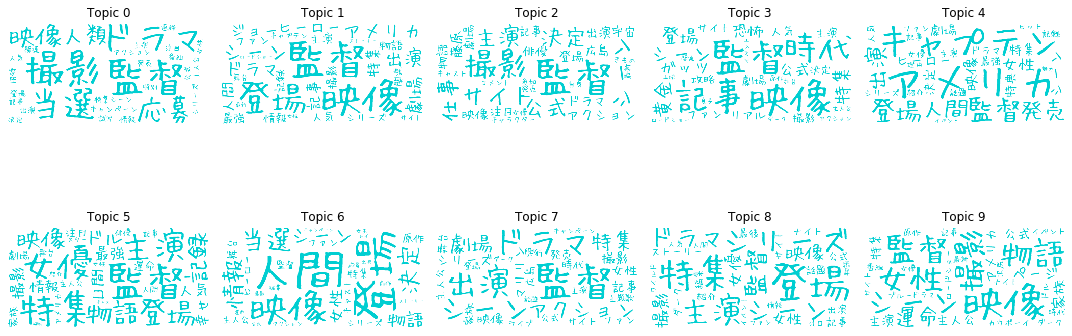

In [13]:
# LDA
num_topics = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=0)

# Visualize
ncols = math.ceil(num_topics/2)
nrows = math.ceil(lda_model.num_topics/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,7))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i, t in enumerate(range(lda_model.num_topics)):

    x = dict(lda_model.show_topic(t, 30))
    im = WordCloud(
        font_path=FONT,
        background_color='white',
        color_func=color_func,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))

plt.tight_layout()
plt.savefig("./visualize.png")

In [14]:
# pyLDAvis
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(vis, './pyldavis_output.html')

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
